# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Описание данных:**

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — общая площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении



### Откроем файл с данными и изучите общую информацию. 

**Импортируем необходимые библиотеки и ознакомимся с датасетом.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
df.info()
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Некоторые столбцы содержат неверный формат - необходимо будет изменить его. 
Также присутствуют пропуски в значениях - необходимо найти логическую замену этим пропускам или оставить их пустыми, если такой замены найти нвозможно. Столбец 'cityCenters_nearest' содержит заглавные буквы - переименуем его.

In [2]:
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

#Проверим результат
df.columns.tolist()

['total_images',
 'last_price',
 'total_area',
 'first_day_exposition',
 'rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'is_apartment',
 'studio',
 'open_plan',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'city_centers_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

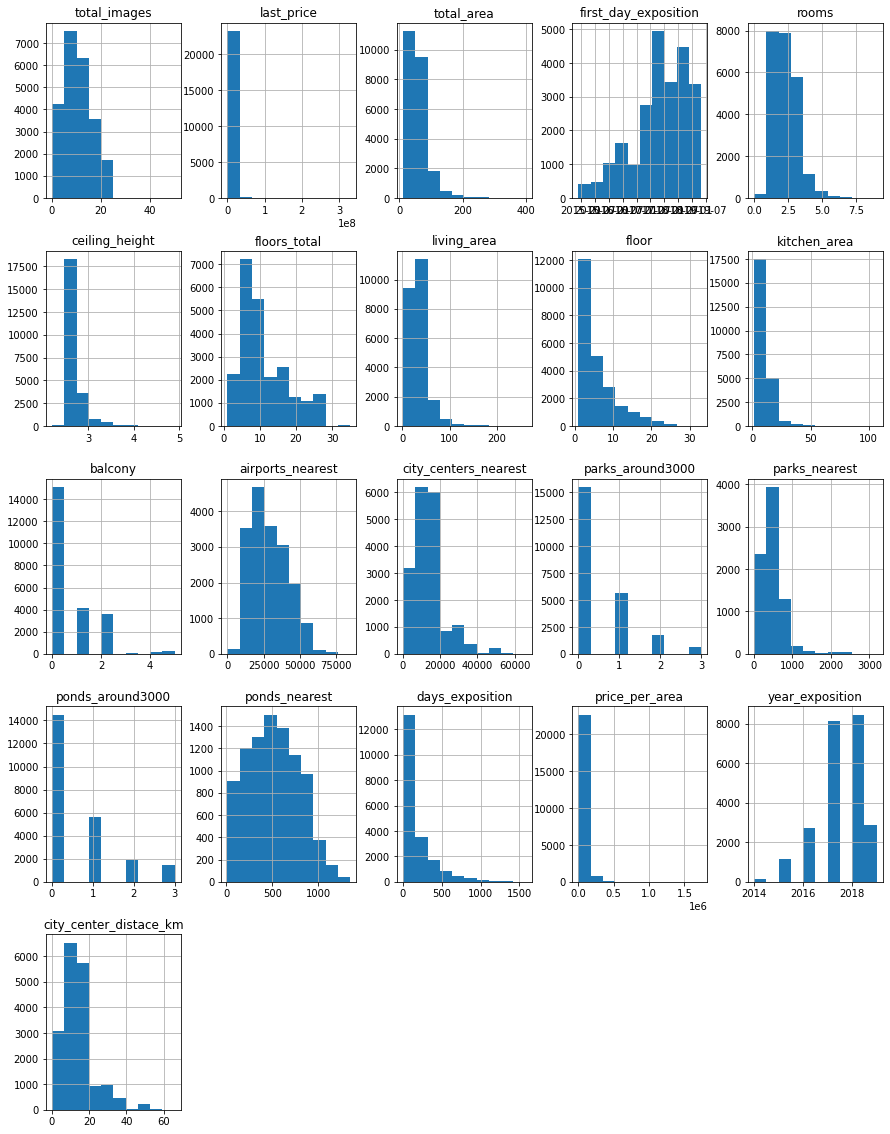

In [51]:
df.hist(figsize=(15, 20));

Некоторые столбцы содержат неверный формат - необходимо будет изменить его. 
Также присутствуют пропуски в значениях - необходимо найти логическую замену этим пропускам или оставить их пустыми, если такой замены найти нвозможно. Столбец 'cityCenters_nearest' содержит заглавные буквы - переименуем его.

### Предобработка данных

**Опеределяем количество пропущеных значений в датасете:**

In [4]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Столбцы 'ceiling_height','living_area' и 'kitchen_area' заполним медианными значениями.
В столбце 'balcony' пропуски вероятнее всего появились из за того что его просто нет на этом объекте. Эти данные нужно исправить на значения - '0'.
Пропуски в столбце 'is_apartment' появились по той же причине что и в 'balcony' - вероятнее всего пропуск появился по причине того что этот объект не является апартаментами и продавец не стал указывать этот параметр. Строки с пропусками
'locality_name' придется удалить, т.к эти данные бесполезны ( Объявления без привязки к локации покупателями просматриваться скорее всего не будут)

Пропуски в 'parks_around3000' и 'ponds_around3000' вероятнее всего не указаны, т.к рядом нет этих объектов и нужно заменить пропуски на значения - '0'

Данные из столбцов 'parks_nearest','airports_nearest','city_сenters_nearest','ponds_nearest' придется оставить без изменения, т.к использовать медианные значения для заполнения пропусков нельзя - это исказит данные. Так же данных для определения локации объекта у нас нет.

Пропуски в столбце 'days_exposition' вероятнее всего указывают на то что объявление было опубликовано в этот же день - заменим пропуски нулями.

In [5]:
#Изменяем типы данных на корректные и заполняем нулями пропуски

#Изменяем тип данных и заполняем отсутствующие значения

df['last_price']= df['last_price'].astype('Int64')
df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%d')
df['is_apartment']= df['is_apartment'].fillna(False)
df['balcony']= df['balcony'].astype('Int64').fillna(0)
df['floors_total']= df['floors_total'].astype('Int64')
df['last_price']= df['last_price'].astype('Int64')
df['ponds_around3000']= df['ponds_around3000'].astype('Int64').fillna(0)
df['parks_around3000']= df['parks_around3000'].astype('Int64').fillna(0)
df['days_exposition']= df['days_exposition'].round().astype('Int64')


#Заполняем медианными значениями отсутствующие данные в параметрах площади квартиры где это возможно

df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df['living_area'] = df['living_area'].fillna(df.groupby(['total_area'])['living_area'].transform('median'))
df['kitchen_area'] = df['kitchen_area'].fillna(df.groupby(['total_area'])['kitchen_area'].transform('median'))

Столбец 'floors_total' имеет 86 пропусков - давайте выясним могут ли быть в этом столбце пропуски связаны с тем, что этот объект является одноэтажным строением и пропуски были указаны намерено

In [6]:
df[df['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000,65.2,2018-10-02,2,2.65,<NA>,30.80,4,False,...,12.00,0,Санкт-Петербург,39197.0,12373.0,1,123.0,0,NaN,49
237,4,2438033,28.1,2016-11-23,1,2.65,<NA>,20.75,1,False,...,6.80,0,Санкт-Петербург,22041.0,17369.0,0,NaN,1,374.0,251
457,4,9788348,70.8,2015-08-01,2,2.65,<NA>,38.40,12,False,...,10.63,0,Санкт-Петербург,37364.0,8322.0,2,309.0,2,706.0,727
671,4,6051191,93.6,2017-04-06,3,2.65,<NA>,47.10,8,False,...,16.80,0,Санкт-Петербург,22041.0,17369.0,0,NaN,1,374.0,123
1757,5,3600000,39.0,2017-04-22,1,2.65,<NA>,18.00,9,False,...,10.00,0,Санкт-Петербург,22735.0,11618.0,1,835.0,1,652.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000,63.5,2017-05-24,2,2.80,<NA>,37.00,3,False,...,10.70,0,Санкт-Петербург,51340.0,15363.0,0,NaN,1,853.0,512
22656,4,4574160,64.5,2017-04-02,2,2.65,<NA>,31.70,20,False,...,14.40,0,Санкт-Петербург,22041.0,17369.0,0,NaN,1,374.0,127
22808,0,14569263,110.4,2016-11-20,3,2.65,<NA>,45.38,6,False,...,23.42,0,Санкт-Петербург,19095.0,4529.0,0,NaN,0,NaN,260
23590,0,21187872,123.3,2017-04-25,3,2.65,<NA>,50.40,18,False,...,23.60,0,Санкт-Петербург,19095.0,4529.0,0,NaN,0,NaN,104


В столбце 'floor' указаны разные этажи - это говрит о том, что объекты не одноэтажные строения и скорее всего пропуск был допущен по ошибке. Заменить это значение медианным так же невозможно, т.к они могут оказаться больше фактического этажа объекта с пропуском - оставим как есть.

In [7]:
#Еще раз првоерим насколько сократилось количество пропусков
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area               143
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              205
balcony                     0
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

Неявные дубликаты могут содеражаться в столбце 'locality_name'. Проверим уникальные значения этого столбца и их количество

In [8]:
print(df['locality_name'].unique())
len(df['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

365

Уберем неявные дубликаты:

In [9]:
#Удалим пропуски в столбце которые мы определили ранее как ненужные для исследования

df = df.dropna(subset=['locality_name'])

#Приведем все названию к строчному регистру 

df['locality_name']= df['locality_name'].str.lower()
df['locality_name'] = df['locality_name'].str.replace('ё', 'е', regex=True)
len(df['locality_name'].unique())

330

Убрали 35 дубля. Отлично.
Но по прежнему в списке присутствуют неявные дубликаты которые могут дублироваться с использованием дополнительного описания (Дервевня, Поселок, ПГТ и т.д) Уберем эти дубликаты

In [10]:
df['locality_name'] = df['locality_name'].replace('городского типа|деревня|село|поселок|\
    #|пок|садовое товарищество|городской|при железнодорожной станции|станции','', regex=True)
df['locality_name'] = df['locality_name'].str.strip()
len(df['locality_name'].unique())

306

Минус еще 24 дубликата. Теперь рассмотрим весь датасет на наличие аномальных значений

In [11]:
df.describe(include= 'all')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23650.000000,2.365000e+04,23650.000000,23650,23650.000000,23650.000000,23565.000000,23507.000000,23650.000000,23650,...,23445.000000,23650.000000,23650,18116.000000,18139.000000,23650.000000,8064.000000,23650.000000,9085.000000,20470.000000
unique,NaN,NaN,NaN,1491,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,2018-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,санкт-петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,368,NaN,NaN,NaN,NaN,NaN,23600,...,NaN,NaN,15721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,2014-11-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-05-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.862326,6.541127e+06,60.329069,NaN,2.070106,2.724311,10.675875,34.454650,5.893277,NaN,...,10.454417,0.591712,NaN,28803.225878,14197.860742,0.469091,490.830729,0.590359,518.059879,180.753200
std,5.682278,1.089640e+07,35.661808,NaN,1.078620,0.989255,6.594823,21.841488,4.883317,NaN,...,5.779654,0.959662,NaN,12637.314144,8606.830295,0.748458,342.554386,0.883539,277.841733,219.777916
min,0.000000,1.219000e+04,12.000000,NaN,0.000000,1.000000,1.000000,2.000000,1.000000,NaN,...,1.300000,0.000000,NaN,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,NaN,1.000000,2.600000,5.000000,18.600000,2.000000,NaN,...,7.000000,0.000000,NaN,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,45.000000


В значениях 'ceiling_height' ,'floors_total, 'total_area', 'kitchen_area', 'rooms' и 'living_area' есть редкие и выбивающиеся значения. Большие значения в 4 последних столбцах из этого списка связаны с редкими, но реальными объявлениями. Исправим значения в столбце 'ceiling_height'

In [12]:
df= df[(df['ceiling_height']<5)&(df['ceiling_height']>2)]
df= df[df['floors_total'] < 36]
df= df[df['total_area'] < 400]
df= df[df['rooms'] < 10]
df.describe(include= 'all')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23475.000000,2.347500e+04,23475.000000,23475,23475.000000,23475.000000,23475.000000,23349.000000,23475.000000,23475,...,23293.000000,23475.000000,23475,17974.000000,17995.000000,23475.000000,7988.000000,23475.000000,8993.000000,20325.000000
unique,NaN,NaN,NaN,1488,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,2018-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,санкт-петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,364,NaN,NaN,NaN,NaN,NaN,23429,...,NaN,NaN,15585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,2014-11-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-05-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.877103,6.363798e+06,59.737531,NaN,2.061853,2.695667,10.677444,34.194499,5.876038,NaN,...,10.410689,0.592929,NaN,28802.515689,14208.997166,0.467732,490.780170,0.588498,519.133771,180.693333
std,5.676717,8.115812e+06,31.990496,NaN,1.043205,0.213384,6.575667,20.349552,4.867335,NaN,...,5.614583,0.959298,NaN,12639.052537,8607.166049,0.747217,342.096665,0.882529,277.962227,219.607280
min,0.000000,1.219000e+04,12.000000,NaN,0.000000,2.200000,1.000000,2.000000,1.000000,NaN,...,1.300000,0.000000,NaN,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,NaN,1.000000,2.600000,5.000000,18.600000,2.000000,NaN,...,7.000000,0.000000,NaN,18551.000000,9269.000000,0.000000,288.000000,0.000000,294.000000,45.000000


Аномальные значения исправлены. Теперь проверим данные на наличие дубликатов:

In [13]:
df.duplicated().sum()

0

Отлично, дубликатов нет. После очистики датасета от пропусков, неявных дубликатов и аномальных значений - можно приступить к добавлению новых столбцов необходимых  для исследования

### Посчитайте и добавьте в таблицу новые столбцы

In [14]:
#Добавим столбец со значениями  - цена одного квадратного метра
df['price_per_area'] = df['last_price'] / df['total_area']

#Добавим столбецы со значениями - день недели , месяц и год публикации объявления
df['day_of_week_exposition'] = df['first_day_exposition'].dt.day_name()
df['month_exposition'] = df['first_day_exposition'].dt.month_name()
df['year_exposition'] = df['first_day_exposition'].dt.year



In [15]:
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_area,day_of_week_exposition,month_exposition,year_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1,482.0,2,755.0,<NA>,120370.37037,Thursday,March,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,18603.0,0,NaN,0,NaN,81,82920.792079,Tuesday,December,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,13933.0,1,90.0,2,574.0,558,92785.714286,Thursday,August,2015
3,0,64900000,159.0,2015-07-24,3,2.65,14,95.0,9,False,...,6800.0,2,84.0,3,234.0,424,408176.100629,Friday,July,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2,112.0,1,48.0,121,100000.0,Tuesday,June,2018


Все в порядке. Теперь добавим тип этажа квартиры

In [16]:
def floor_type_calc(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [17]:
df['floor_type'] = df.apply(floor_type_calc, axis=1)
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_area,day_of_week_exposition,month_exposition,year_exposition,floor_type
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1,482.0,2,755.0,<NA>,120370.37037,Thursday,March,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,NaN,0,NaN,81,82920.792079,Tuesday,December,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,1,90.0,2,574.0,558,92785.714286,Thursday,August,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.65,14,95.0,9,False,...,2,84.0,3,234.0,424,408176.100629,Friday,July,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2,112.0,1,48.0,121,100000.0,Tuesday,June,2018,другой


Добавим столец  - расстояние в км до центра города

In [18]:
#Добавляем новый столбец с росстояние до центра и окргуляем это значение до целых чисел
df['city_center_distace_km'] = df['city_centers_nearest']/1000
df['city_center_distace_km'] = df['city_center_distace_km'].round()
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_area,year_exposition,city_center_distace_km
count,23475.000000,2.347500e+04,23475.000000,23475.000000,23475.000000,23475.000000,23349.000000,23475.000000,23293.000000,23475.000000,17974.000000,17995.000000,23475.000000,7988.000000,23475.000000,8993.000000,20325.000000,2.347500e+04,23475.000000,17995.000000
mean,9.877103,6.363798e+06,59.737531,2.061853,2.695667,10.677444,34.194499,5.876038,10.410689,0.592929,28802.515689,14208.997166,0.467732,490.780170,0.588498,519.133771,180.693333,9.913782e+04,2017.370564,14.202834
std,5.676717,8.115812e+06,31.990496,1.043205,0.213384,6.575667,20.349552,4.867335,5.614583,0.959298,12639.052537,8607.166049,0.747217,342.096665,0.882529,277.962227,219.607280,4.801244e+04,1.037252,8.615126
min,0.000000,1.219000e+04,12.000000,0.000000,2.200000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18551.000000,9269.000000,0.000000,288.000000,0.000000,294.000000,45.000000,7.659967e+04,2017.000000,9.000000
50%,9.000000,4.630000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26765.000000,13109.000000,0.000000,455.000000,0.000000,503.000000,95.000000,9.500000e+04,2017.000000,13.000000
75%,14.000000,6.750000e+06,69.500000,3.000000,2.700000,16.000000,42.200000,8.000000,11.800000,1.000000,37288.000000,16293.000000,1.000000,612.000000,1.000000,732.000000,231.000000,1.141606e+05,2018.000000,16.000000
max,50.000000,3.300000e+08,398.000000,9.000000,4.900000,35.000000,260.000000,33.000000,107.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.736842e+06,2019.000000,66.000000


### Проведите исследовательский анализ данных

Изучим параметры объектов отдельно

<AxesSubplot:>

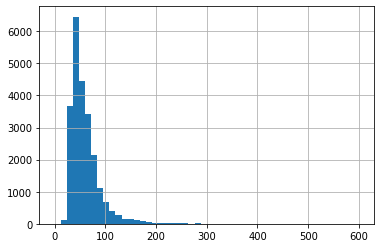

In [19]:
# Построим гистограмму по столбцу "общая площадь"

df['total_area'].hist(bins=50,range=(0,600))

Основные значения распределились в области между 30-70 метров кв. На графике нет каких-либо аномальных значений, все в пределах нормальных значений: Много объектов стандартных размеров большенства жилых квартир, так же на рынке присутсвуют объекты большой площади более 100 метров, но в гораздо меньших количествах

<AxesSubplot:>

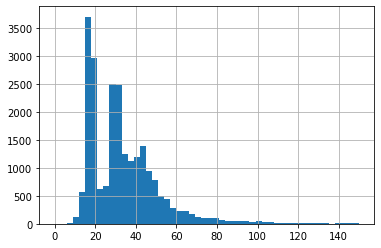

In [20]:
# Построим гистограмму по столбцу "жилая площадь"
df['living_area'].hist(bins=50,range=(0,150))

График показывает 2 значительных пика для значений менее 20 метров и 30 метров. Аномальных значений нет. Объекты с жилой площадью более 40 метров присутствуют, но в меньших количествах 

<AxesSubplot:>

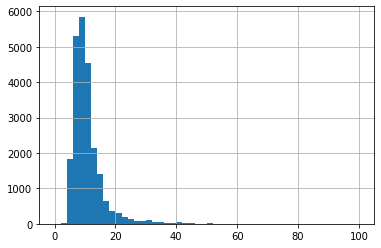

In [21]:
# Построим гистограмму по столбцу "площадь кухни"
df['kitchen_area'].hist(bins=50,range=(0,100))

Никаких аномальных значений на графике не обноружено. Асолютно ожидаемые значения для большенства квартир: от 5м до 15м для большенства объектов

<AxesSubplot:>

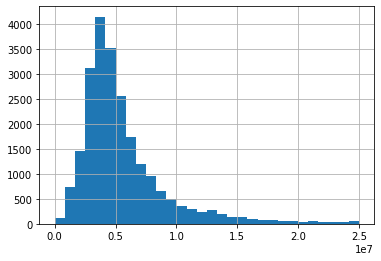

In [22]:
# Построим гистограмму по столбцу "цена объекта"
df['last_price'].hist(bins=30,range=(0,25000000))

Нормальное распередление на графике. Большенство объектов распределены в значениях от 2.5 до 5 млн. Аномальных значений нет.

<AxesSubplot:>

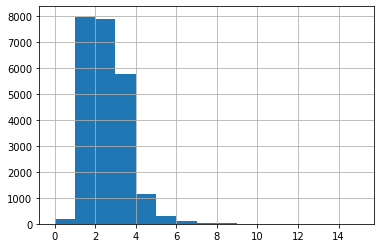

In [23]:
# Построим гистограмму по столбцу "количество комнат"
df['rooms'].hist(bins=15,range =(0,15))

На этом графике не заметно никаких аномальных значений. Все сосвершенно страндартно большенство кваритра 1-2 комнатные.

<AxesSubplot:>

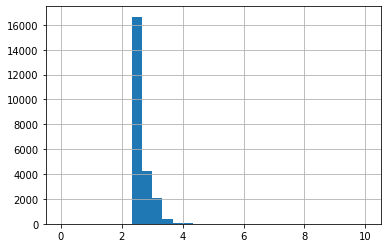

In [24]:
# Построим гистограмму по столбцу "высота потолков"
df['ceiling_height'].hist(bins=30,range =(0,10))

Все как ожидалось, большенство квартир имеют стандартную высоту потолков. Т.к мы убрали ошибочные значения - аномальных значений на графике тоже нет.

<AxesSubplot:>

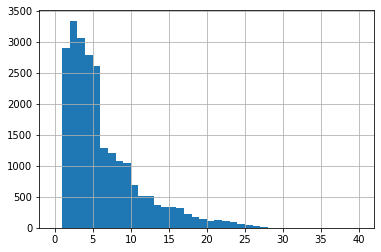

In [25]:
#Построим гистограмму по столбцу "этаж квартиры"
df['floor'].hist(bins=40,range =(0,40))

Гистограмма отображает ожидаемое распределение. Средняя этажность в Санк-Петербурге на сегодня 15 этажей. Скорее всего объявления в данном датасете приимущественно старого фонда - эту теорию мы сможем подтвердить при анализе столбца - 'floors_total'

<AxesSubplot:>

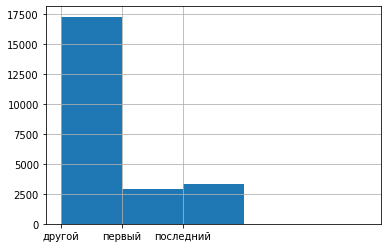

In [26]:
#Построим гистограмму по столбцу "общее количество этажей в доме"
df['floor_type'].hist(bins=5,range =(0,5))

Эта гистограмма очевидно дает нам понять что объявлений в которых указан первый и последний этаж в 7 раз меньше от основной массы. Тут сложно сделать какие либо выводы - все очевидно.

<AxesSubplot:>

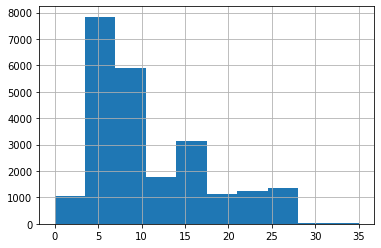

In [27]:
#Построим гистограмму по столбцу "тип этажа квартиры"
df['floors_total'].hist(bins=10,range =(0,35))

Гипотеза вероятно подтвердилась: возможно в выгрузке большинство домов - "хрущевки". Но так же застройка спальных районов современными жк, в которых более 15 этажей, повлияла на распределения в гистограмме: таких домов тут почти 7 тысяч.

<AxesSubplot:>

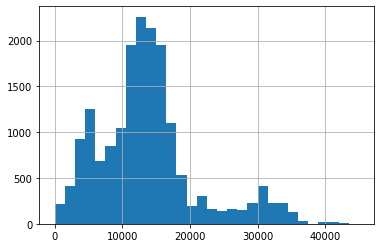

In [28]:
#Построим гистограмму по столбцу "расстояние до центра города в метрах"
df['city_centers_nearest'].hist(bins=30,range =(0,45000))

Распределение значений на гистограмме говорит о том, что большая часть квартир находится на расстоянии более 13.000м от центра города (но это еще не область). Значения превышающие более 17.000м - вероятнее всего относятся в объектам в области и крупным отдаленным районам Санк-Петербурга (Мурино,Парнас) Так же нужно помнить что в данных по этому параметру у нас было более 5.000 пропусков. Объективность оценки может быть ошибочной.

<AxesSubplot:>

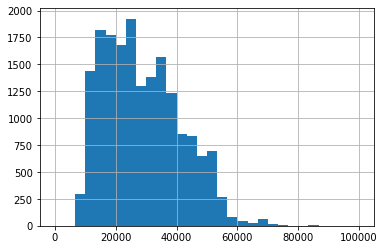

In [29]:
#Построим гистограмму по столбцу "расстояние до ближайшего аэропорта"
df['airports_nearest'].hist(bins=30,range =(0,100000))

Распределение значений на гистограмме относительно равномерное. Сделать каких-либо однозначных выводов нельзя. Так же нужно помнить что в данных по этому параметру у нас было более 5.000 пропусков

<AxesSubplot:>

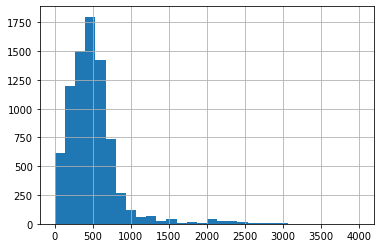

In [30]:
#Построим гистограмму по столбцу "расстояние до ближайшего парка"
df['parks_nearest'].hist(bins=30,range =(0,4000))

Большая часть домов по данным этой гистограммы находить на расстоянии от 300 до 600 метров. Но мы не можем доверять этому параметру, т.к в нашем датасете более 15.000 пропусков для этого параметра.

<AxesSubplot:>

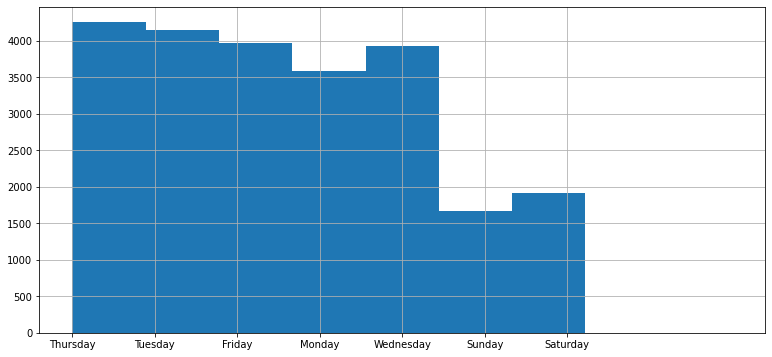

In [31]:
#Построим гистограммы по столбцам "день и месяц публикации объявления"
df['day_of_week_exposition'].hist(bins=9,range =(0,8),figsize=(13, 6))

<AxesSubplot:>

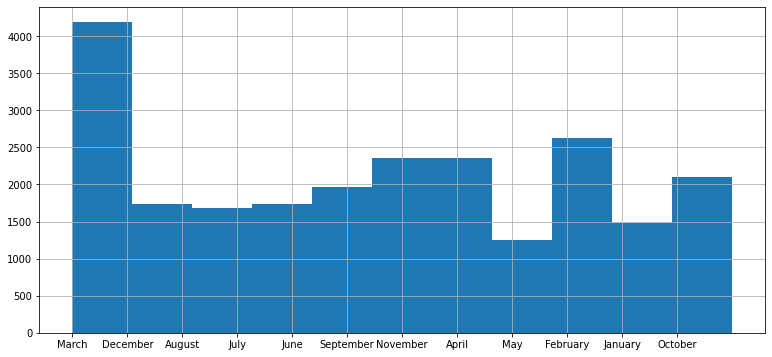

In [32]:
df['month_exposition'].hist(bins=11,range =(0,12),figsize=(13, 6))

Публикация объявлений распределена равномерно в течении всей рабочей недели. В выходные агенты недвижимости вероятно занимаются своими личными делами. Гистограмма с зависимостью от месяца публикации говорит о том что пик приходится на Март (Интересно с чем это связано? ) 

***Решаем следующие задачи:***
1. Как быстро продавались квартиры?
2. Какие факторы больше всего влияют на общую (полную) стоимость объекта?
3. Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.
4. Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

**1)Как быстро продавались квартиры?**

count    20325.000000
mean       180.693333
std        219.607280
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64
        days_exposition
mean         180.693333
median        95.000000


<AxesSubplot:>

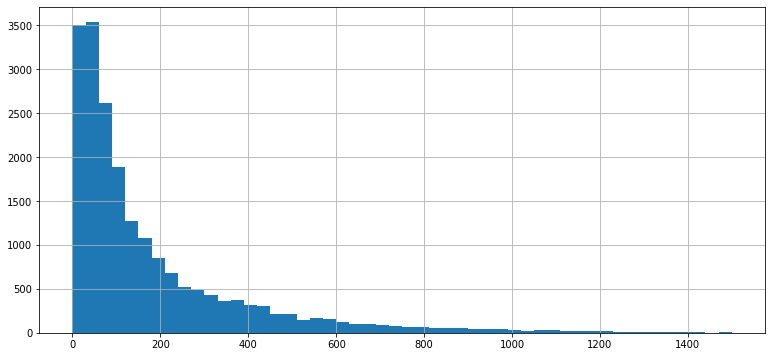

In [33]:
#Построим гистограмму по столбцу " сколько дней было размещено объявление" и найдем среднее знаение и медиану по данному параметру
print(df['days_exposition'].describe())
print(df.agg({'days_exposition': ['mean', 'median']}))
df['days_exposition'].hist(bins=50,range =(0,1500),figsize=(13, 6))

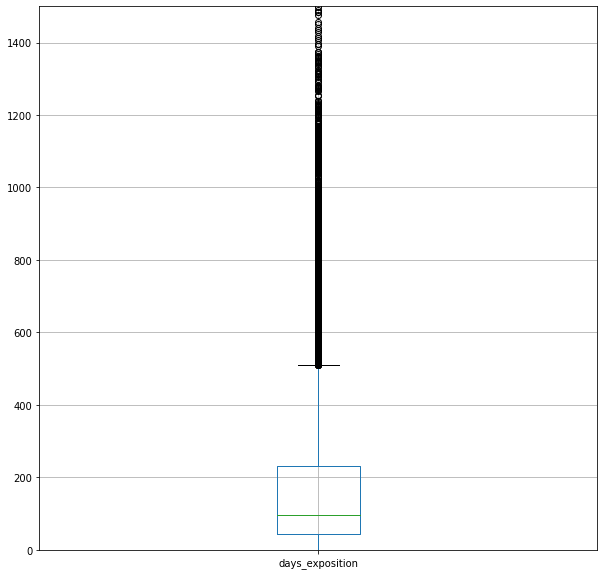

In [34]:
plot_by_exposition = df.boxplot('days_exposition',figsize=(10,10)).set_ylim(0,1500)

Среднее и медиана расходятся более чем в 2 раза. Графики показывают что данные равномерно распределены и мы имеем достаточно много быстрых продаж, так и продажи более 200 дней имеют большее количество

Основываясь на имеющихся данных можно сказать что среднее время продажи состовляет 95 дней, быстрые продажи - продажи которые происходят в пириод до 50 дней. Необычно долгими продажами можно считать продажи, которые разделены границей четвертого квартиля - от 400 дней и более

**2)Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

In [35]:
#Выведем датасет для удобства
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_area,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_center_distace_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,<NA>,120370.37037,Thursday,March,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0,NaN,81,82920.792079,Tuesday,December,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558,92785.714286,Thursday,August,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,95.0,9,False,...,84.0,3,234.0,424,408176.100629,Friday,July,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1,48.0,121,100000.0,Tuesday,June,2018,другой,8.0


In [36]:
corr_by_price = df[['total_area',\
           'last_price',\
           'living_area',\
           'kitchen_area',\
           'rooms']].corr()
corr_by_price.style.background_gradient()

,total_area,last_price,living_area,kitchen_area,rooms
total_area,1.000000,0.687010,0.937266,0.607299,0.778287
last_price,0.687010,1.000000,0.608260,0.531718,0.400033
living_area,0.937266,0.608260,1.000000,0.415855,0.849629
kitchen_area,0.607299,0.531718,0.415855,1.000000,0.269166
rooms,0.778287,0.400033,0.849629,0.269166,1.000000


<AxesSubplot:xlabel='floor_type'>

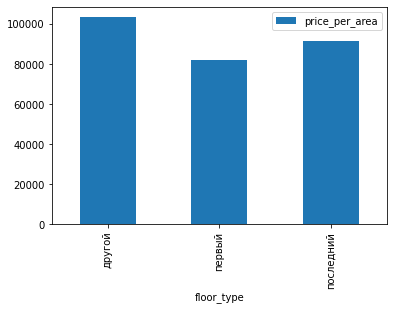

In [37]:
mean_floor = df.groupby('floor_type').agg({'price_per_area':'mean'})
mean_floor.plot.bar()

<AxesSubplot:xlabel='day_of_week_exposition'>

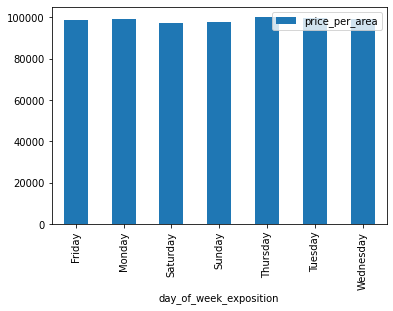

In [38]:
mean_day = df.groupby('day_of_week_exposition').agg({'price_per_area':'mean'})
mean_day.plot.bar()

<AxesSubplot:xlabel='month_exposition'>

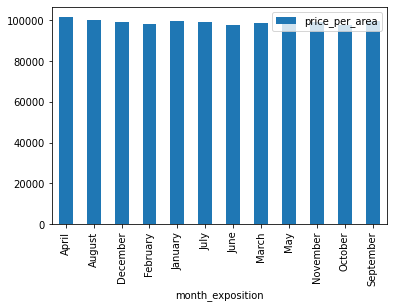

In [39]:
mean_month = df.groupby('month_exposition').agg({'price_per_area':'mean'})
mean_month.plot.bar()

<AxesSubplot:xlabel='year_exposition'>

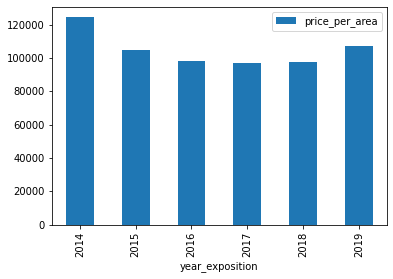

In [40]:
mean_year = df.groupby('year_exposition').agg({'price_per_area':'mean'})
mean_year.plot.bar()

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

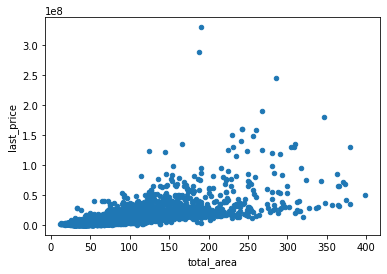

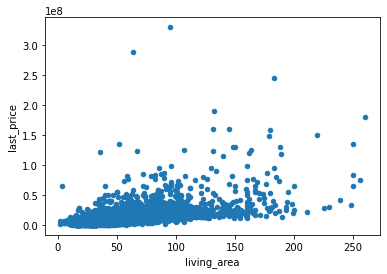

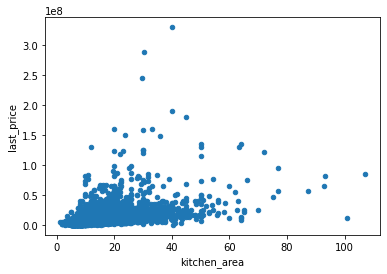

In [41]:
df.plot(x='total_area', y='last_price', kind='scatter')
df.plot(x='living_area', y='last_price', kind='scatter') 
df.plot(x='kitchen_area', y='last_price', kind='scatter') 

**Вывод:** Цена не зависит от дня и месяца публикации, но сильно зависит от этажа квартиры и от года. Логично предположить что квартиры на первом этаже мене востребованы, квартиры на последнем этаже стоят так же дороже чем на первом.График зависимости средней цены от года показывает что цены в 2014 году были выше - вероятнее всего это последствия экономического кризиса в 2014 году.

Зависимость цены от общей, жилой, кухонной площади так же прослеживаются: В большей степени от общей и жилой площади, чуть в меньшей от площади кухни.

**3)Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

In [42]:
#Найдем среднюю цену кв.метра для каждого города и отсортируем в порядке убывания
df.groupby('locality_name').agg({'price_per_area':'mean'}).sort_values(by='price_per_area', ascending=False).head(10)

,price_per_area
locality_name,
зеленогорск,115122.799198
санкт-петербург,114467.514275
репино,104238.614786
пушкин,103125.819291
сестрорецк,101757.616875
лисий нос,100660.814239
мистолово,98549.976709
левашово,96997.690531
кудрово,95261.96345


In [43]:
#Добавим новый столбец в котором разделим объекты на город и область

def locality_type(row):
    if row['locality_name'] == 'санкт-петербург':
        return 'Санкт-петербург'
    else:
        return 'Область'

df['town_type'] = df.apply(locality_type, axis=1)


In [44]:
#Найдем для каждого города количество объявлений и отсортируем их в порядке убывания по средней цене
top_expensive_by_sqrm = df.groupby('locality_name').agg({'town_type':'count','price_per_area':'mean'})
top_expensive_by_sqrm = top_expensive_by_sqrm.sort_values('town_type', ascending=False).head(11)
top_expensive_by_sqrm.sort_values('price_per_area', ascending=False)

,town_type,price_per_area
locality_name,,
санкт-петербург,15585,114467.514275
пушкин,369,103125.819291
кудрово,469,95261.96345
парголово,327,90175.913458
мурино,584,86018.110911
петергоф,201,84757.55969
шушары,439,78551.344545
колпино,338,75424.579098
гатчина,306,68757.678644


In [45]:
#Построим линейный и столбчатые графики зависимости цены от города

<AxesSubplot:xlabel='locality_name'>

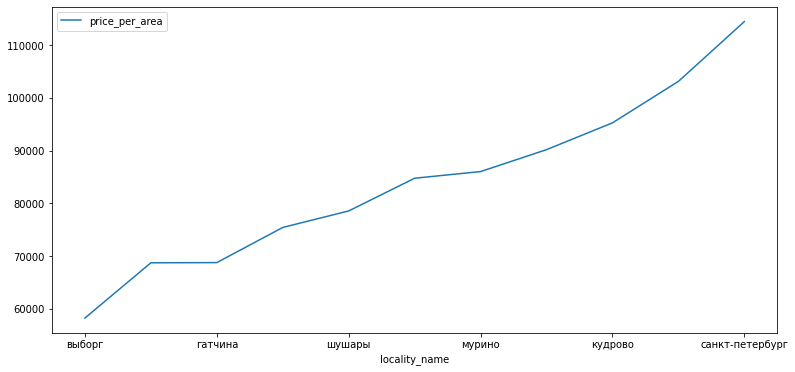

In [46]:
top_expensive_by_sqrm.sort_values('price_per_area', ascending=True)\
    .drop('town_type', axis=1).plot(figsize=(13, 6))

<AxesSubplot:xlabel='locality_name'>

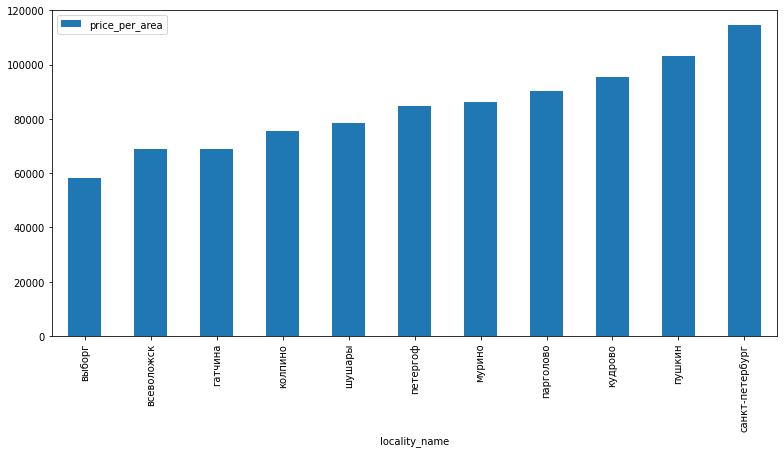

In [47]:
top_expensive_by_sqrm.sort_values('price_per_area', ascending=True)\
    .drop('town_type', axis=1).plot(kind='bar',figsize=(13, 6))

**Вывод:**Самая высокая цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений - в Санк-Петербурге(114.467р). Самая низкая - в Выборге(58.238р). 

**4)Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.**

In [48]:
#Назначим для каждого киллометра удаленности от центра свою категорию

def center_distance_rangetype(row):
    if row['city_center_distace_km'] <1:
        return 'менее 1 км до центра'
    elif 1 <=row['city_center_distace_km'] < 2:
        return '1 км до центра'
    elif 2 <=row['city_center_distace_km'] < 3:
        return '2 км до центра'
    elif 3 <=row['city_center_distace_km'] < 4:
        return '3 км до центра'
    elif 4 <=row['city_center_distace_km'] < 5:
        return '4 км до центра'
    elif 5 <=row['city_center_distace_km'] < 6:
        return '5 км до центра'
    elif 6 <=row['city_center_distace_km'] < 7:
        return '6 км до центра'
    elif 7 <=row['city_center_distace_km'] < 8:
        return '7 км до центра'
    elif 8 <=row['city_center_distace_km'] < 9:
        return '8 км до центра'
    elif 9 <=row['city_center_distace_km'] < 10:
        return '9 км до центра'
    elif 10 <=row['city_center_distace_km'] < 11:
        return '10 км до центра'
    elif 11 <=row['city_center_distace_km'] < 12:
        return '11 км до центра'
    elif 12 <=row['city_center_distace_km'] < 13:
        return '12 км до центра'
    elif 13 <=row['city_center_distace_km'] < 14:
        return '13 км до центра'
    elif 14 <=row['city_center_distace_km'] < 15:
        return '14 км до центра'
    elif 15 <=row['city_center_distace_km'] < 16:
        return '15 км до центра'
    else:
        return 'Более 15 км от центра'

df['center_distance_type'] = df.apply(center_distance_rangetype,axis = 1)

df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_area,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_center_distace_km,town_type,center_distance_type
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,755.0,<NA>,120370.37037,Thursday,March,2019,другой,16.0,Санкт-петербург,Более 15 км от центра
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,False,...,NaN,81,82920.792079,Tuesday,December,2018,первый,19.0,Область,Более 15 км от центра
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.30,4,False,...,574.0,558,92785.714286,Thursday,August,2015,другой,14.0,Санкт-петербург,14 км до центра
3,0,64900000,159.00,2015-07-24,3,2.65,14,95.00,9,False,...,234.0,424,408176.100629,Friday,July,2015,другой,7.0,Санкт-петербург,7 км до центра
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,48.0,121,100000.0,Tuesday,June,2018,другой,8.0,Санкт-петербург,8 км до центра
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,False,...,NaN,55,95065.789474,Monday,September,2018,другой,NaN,Область,Более 15 км от центра
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.60,6,False,...,NaN,155,99195.710456,Thursday,November,2017,другой,19.0,Область,Более 15 км от центра
7,5,7915000,71.60,2019-04-18,2,2.65,24,44.30,22,False,...,NaN,<NA>,110544.692737,Thursday,April,2019,другой,12.0,Санкт-петербург,12 км до центра
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,False,...,NaN,189,87454.764777,Wednesday,May,2018,другой,NaN,Область,Более 15 км от центра
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,NaN,289,88524.590164,Sunday,February,2017,другой,15.0,Санкт-петербург,15 км до центра


In [49]:
#сгруппируем данные по средней цене кв.м и расстоянию от центра

df.groupby('center_distance_type').agg({'price_per_area':'mean'}).sort_values(by='price_per_area', ascending=False).head(20)

,price_per_area
center_distance_type,
менее 1 км до центра,245833.530289
1 км до центра,177758.233087
7 км до центра,156161.903272
2 км до центра,155436.311083
6 км до центра,149655.972676
5 км до центра,138837.25124
4 км до центра,130944.910671
8 км до центра,124400.795178
3 км до центра,121135.314774


**Вывод:**Логично предположить что цена кв. метра полностью зависима от удаленности от центра. Удаленные района более 8 километров от центра оказались дешевле по стоимости кв.метра и расположились в внизу списка при сортировке. Но в начале списка расположились значения 6км и 5км. Скорее всего это обусловлено районом расположения данных объектов и логика "чем дальше -тем дороже" тут не работает. Данные квартиры могут быть в раойне Крестовского острова или в Петроградском районе (является одним из самых дорогих районов в городе) и могут завышать среднуюю цену кв. метра для этой зоны удаленности от центра. Цена кв. метра в этих районах соответсвует и находятся как раз на этом расстоянии от центра.

### Общий вывод

• Квартиры в центре города обычно дороже, чем недвижимость на окраинах. Но есть районы\кварталы\жк которые удалены от центра более 5км и имеют высокую стоимость. Так же присутсвуют объекты с высокой стоимостью в области - скорее всего это дома и коттеджи.

• Большая часть объявлений о продаже были опубликованы в марте, это может стать ценной информацией для маркетологов которые работают с этим проектом. Спад активности публикации объявлений приходится на конец недели.

• Самая большая связь зависимости цены от размеров общей площади, жилой площади и типа этажа. Зависимости от дня недели и месяца не наблюдается. Связь зависимости между годом и ценой может отображать более глобальные события ( как повышение цены в 2014 связанное с экономическим кризисом)

• Множество пропусков в параметрах геолокации создает трудности для исследования с этими параметрами. Пропуски в столбцах, 'airports_nearest', 'city_centers_nearest','parks_nearest','ponds_nearest' понижают точность исследование и объективность его выводов

• Самая высокая цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений - в Санк-Петербурге(114.467р). Самая низкая - в Выборге(58.238р).


**Для разработчика:**
    
   1)Провести работу над устранением появления пропусков в данных при выгрузке.
   
   2)Возможно ли устранить появление пропусков в значениях 'airports_nearest', 'city_centers_nearest','parks_nearest','ponds_nearest' даже если пропуски сделаны намерено. Можно ли сделать автоматическое заполнение этих значений основываясь на адресе объекта? 
   
   3)Исправить форматы параметров: цены, количества балконов, даты публикации, количества прудов и парков, количества этажей и дней размещения объявления на корректные.
    
   4)Сделать выбор города, населенного пункта строгой и обязательной категорией с возможностью заполнения только из списка имеющихся значений.